In [16]:
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from continuum import ClassIncremental
from continuum.datasets import CIFAR10
from continuum.tasks import split_train_val

sns.set()

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = CIFAR10("my/data/path", download=True, train=True)

# Define the class-incremental scenario
scenario = ClassIncremental(
    dataset,
    increment=2,  # Add 2 new classes per task
    initial_increment=2  # Start with 2 classes
)

print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

# Define the NN model
class NN(nn.Module):
    def __init__(self, layer_sizes):
        super(NN, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            m = nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            self.linears.append(m)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()
    accuracy = correct / len(labels)
    return accuracy.item()

# Function to calculate NTK (based on simrnn_ntk)
def simrnn_ntk(inputseqs, model):
    grads = []
    for seq in inputseqs:
        model.zero_grad()  # Clear previous gradients
        out = model(seq.unsqueeze(0))  # Add batch dimension
        # Ensure output is a scalar for backward()
        if out.dim() > 0:
            out = out.sum()
        out.backward()  # Compute gradients
        # Collect gradients for all parameters
        grad = torch.cat([p.grad.flatten() if p.grad is not None else torch.zeros_like(p).flatten()
                          for p in model.parameters()])
        grads.append(grad)
    
    batchsize = len(inputseqs)
    ntk = torch.zeros(batchsize, batchsize)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = torch.dot(grads[i], grads[j])
    return ntk

# Function to evaluate the model on a dataset
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y, _ in loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

# Initialize model, loss function, and optimizer
layer_sizes = [32 * 32 * 3] + [100] * 3 + [10]  # Input size: 32x32x3, hidden layers: 100, output size: 10
model = NN(layer_sizes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store results
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
task_accuracies = []  # Accuracy on all tasks after each task
train_ntk_norms = []  # NTK norms for train samples
test_ntk_norms = []   # NTK norms for test samples

# Fixed samples for NTK calculation
fixed_train_samples = []
fixed_val_samples = []

val_tasksets = []

# Train and evaluate on each task
for task_id, train_taskset in enumerate(scenario):
    print(f"\n=== Task {task_id + 1} ===")
    
    # Split the taskset into training and validation sets
    train_taskset, val_taskset = split_train_val(train_taskset, val_split=0.1)
    train_loader = DataLoader(train_taskset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_taskset, batch_size=32, shuffle=False)
    val_tasksets.append(val_taskset)
    
    # Store fixed samples for NTK calculation
    fixed_train_samples.append([train_taskset[i][0] for i in range(10)])
    fixed_val_samples.append([val_taskset[i][0] for i in range(10)])

    # Train the model on the current task
    model.train()
    for epoch in range(5):  # Train for 5 epochs per task
        running_loss = 0.0
        running_accuracy = 0.0
        correct = 0
        total = 0
        for x, y, t in train_loader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on the validation set
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Evaluate the model on all tasks seen so far using fixed validation sets
    task_accuracies.append([])
    for t in range(task_id + 1):
        # Use the stored validation set for task t
        val_loader_t = DataLoader(val_tasksets[t], batch_size=32, shuffle=False)
        _, accuracy = evaluate(model, val_loader_t, criterion)
        task_accuracies[task_id].append(accuracy)
        print(f"Accuracy on Task {t + 1}: {accuracy:.4f}")

    # Calculate NTK for fixed samples
    model.eval()
    train_ntk_norms.append([])
    test_ntk_norms.append([])
    for t in range(task_id + 1):
        train_ntk = simrnn_ntk(fixed_train_samples[t], model)
        test_ntk = simrnn_ntk(fixed_val_samples[t], model)
        train_ntk_norms[task_id].append(torch.norm(train_ntk, p='fro').item())
        test_ntk_norms[task_id].append(torch.norm(test_ntk, p='fro').item())

# Plot results
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Print NTK norms
print("Train NTK Norms:", train_ntk_norms)
print("Test NTK Norms:", test_ntk_norms)

# Plot NTK norms for train and test samples
plt.figure(figsize=(12, 5))
for t in range(len(train_ntk_norms)):
    plt.plot(range(t * 5, (t + 1) * 5), train_ntk_norms[t], label=f'Task {t + 1} Train NTK')
    plt.plot(range(t * 5, (t + 1) * 5), test_ntk_norms[t], label=f'Task {t + 1} Test NTK', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('NTK Norm')
plt.legend()
plt.title('NTK Norms for Train and Test Samples')
plt.show()

Files already downloaded and verified
Number of classes: 10.
Number of tasks: 5.

=== Task 1 ===
Epoch 1, Train Loss: 0.6233, Val Loss: 0.4427, Train Accuracy: 0.7758, Val Accuracy: 0.7990
Epoch 2, Train Loss: 0.4119, Val Loss: 0.3938, Train Accuracy: 0.8134, Val Accuracy: 0.8230
Epoch 3, Train Loss: 0.3937, Val Loss: 0.3981, Train Accuracy: 0.8183, Val Accuracy: 0.8140
Epoch 4, Train Loss: 0.3696, Val Loss: 0.3694, Train Accuracy: 0.8328, Val Accuracy: 0.8410
Epoch 5, Train Loss: 0.3577, Val Loss: 0.3774, Train Accuracy: 0.8378, Val Accuracy: 0.8230
Accuracy on Task 1: 0.8230

=== Task 2 ===
Epoch 1, Train Loss: 1.0065, Val Loss: 0.6058, Train Accuracy: 0.5942, Val Accuracy: 0.6800


KeyboardInterrupt: 

In [3]:
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from continuum import ClassIncremental
from continuum.datasets import CIFAR100
from continuum.tasks import split_train_val

sns.set()

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = CIFAR100("my/data/path", download=True, train=True)

# Define the class-incremental scenario
scenario = ClassIncremental(
    dataset,
    increment=5,  # Add 2 new classes per task
    initial_increment=5  # Start with 2 classes
)

print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

# Define the NN model
class NN(nn.Module):
    def __init__(self, layer_sizes):
        super(NN, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            m = nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            self.linears.append(m)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x
    
class SimpleRNNClassifier(nn.Module):
    def __init__(self, indim, statedim, outdim=1, nonlin=torch.erf, varw=1, varu=1, varb=0, varv=1,
                 avgpool=False, debug=False):
        super().__init__()
        self.varu = varu
        self.varw = varw
        self.varb = varb
        self.varv = varv
        self.nonlin = nonlin
        self.avgpool = avgpool
        self.debug = debug
        self.W = nn.Parameter(torch.randn(statedim, statedim))
        self.U = nn.Parameter(torch.randn(indim, statedim))
        self.b = nn.Parameter(torch.randn(statedim))
        self.v = nn.Parameter(torch.randn(statedim, outdim))
        self.randomize()

    def forward(self, inp, initstate=0):
        # Flatten the input to [batch_size, features]
        inp = inp.view(inp.size(0), -1)  # Flatten to [batch_size, indim]
        indim = self.U.shape[0]
        statedim = self.U.shape[1]
        embed = torch.einsum('bi,ij->bj', inp, self.U) / np.sqrt(indim) + self.b
        seqlen = 1  # Since we flattened the input, seqlen is 1
        state = initstate
        self._states = []
        self.hs = []
        for i in range(seqlen):
            h = embed + state  # embed is [batch_size, statedim], state is [batch_size, statedim]
            state = self.nonlin(h)
            self._states.append(state)
            if self.debug:
                state.retain_grad()
                self.hs.append(h)
            if i < seqlen - 1:
                state = state @ self.W / np.sqrt(statedim)
            else:
                if self.avgpool:
                    meanstate = sum(self._states) / len(self._states)
                    return meanstate @ self.v / np.sqrt(statedim)
                else:
                    return state @ self.v / np.sqrt(statedim)

    def randomize(self, varu=None, varw=None, varb=None, varv=None):
        varu = varu or self.varu
        varw = varw or self.varw
        varb = varb or self.varb
        varv = varv or self.varv
        with torch.no_grad():
            self.W.normal_(std=np.sqrt(varw))
            self.U.normal_(std=np.sqrt(varu))
            self.v.normal_(std=np.sqrt(varv))
            if varb > 0:
                self.b.normal_(std=np.sqrt(varb))
            else:
                self.b.zero_()

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()
    accuracy = correct / len(labels)
    return accuracy.item()

# Function to calculate NTK (based on simrnn_ntk)
def simrnn_ntk(inputseqs, model):
    grads = []
    for seq in inputseqs:
        model.zero_grad()  # Clear previous gradients
        out = model(seq.unsqueeze(0))  # Add batch dimension
        # Ensure output is a scalar for backward()
        if out.dim() > 0:
            out = out.sum()
        out.backward()  # Compute gradients
        # Collect gradients for all parameters
        grad = torch.cat([p.grad.flatten() if p.grad is not None else torch.zeros_like(p).flatten()
                          for p in model.parameters()])
        grads.append(grad)
    
    batchsize = len(inputseqs)
    ntk = torch.zeros(batchsize, batchsize)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = torch.dot(grads[i], grads[j])
    return ntk

# Function to evaluate the model on a dataset
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y, t in loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        print(f"evaluate total, correct: {total, correct}") 

    return total_loss / len(loader), correct / total

# # Initialize model, loss function, and optimizer
# layer_sizes = [32 * 32 * 3] + [100] * 3 + [10]  # Input size: 32x32x3, hidden layers: 100, output size: 10
# model = NN(layer_sizes)

indim = 3 * 32 * 32  # CIFAR-10 image size (3 channels, 32x32 pixels)
statedim = 1000
outdim = 100
model = SimpleRNNClassifier(indim, statedim, outdim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store results
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
task_accuracies = []  # Accuracy on all tasks after each task
train_ntk_norms = []  # NTK norms for train samples
test_ntk_norms = []   # NTK norms for test samples

# Fixed samples for NTK calculation
fixed_train_samples = []
fixed_val_samples = []

val_tasksets = []

# Train and evaluate on each task
for task_id, train_taskset in enumerate(scenario):
    print(f"\n=== Task {task_id + 1} ===")
    
    # Split the taskset into training and validation sets
    train_taskset, val_taskset = split_train_val(train_taskset, val_split=0.1)
    train_loader = DataLoader(train_taskset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_taskset, batch_size=32, shuffle=False)
    val_tasksets.append(val_taskset)
    
    # Store fixed samples for NTK calculation
    fixed_train_samples.append([train_taskset[i][0] for i in range(10)])
    fixed_val_samples.append([val_taskset[i][0] for i in range(10)])

    # Train the model on the current task
    model.train()
    for epoch in range(1):  # Train for 5 epochs per task
        running_loss = 0.0
        running_accuracy = 0.0
        correct = 0
        total = 0
        for x, y, t in train_loader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on the validation set
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Evaluate the model on all tasks seen so far using fixed validation sets
    task_accuracies.append([])
    for t in range(task_id + 1):
        # Use the stored validation set for task t
        val_loader_t = DataLoader(val_tasksets[t], batch_size=32, shuffle=False)
        _, accuracy = evaluate(model, val_loader_t, criterion)
        task_accuracies[task_id].append(accuracy)
        print(f"Accuracy on Task {t + 1}: {accuracy:.4f}")

    # Calculate NTK for fixed samples
    model.eval()
    train_ntk_norms.append([])
    test_ntk_norms.append([])
    for t in range(task_id + 1):
        train_ntk = simrnn_ntk(fixed_train_samples[t], model)
        test_ntk = simrnn_ntk(fixed_val_samples[t], model)
        train_ntk_norms[task_id].append(torch.norm(train_ntk, p='fro').item())
        test_ntk_norms[task_id].append(torch.norm(test_ntk, p='fro').item())



Files already downloaded and verified
Number of classes: 100.
Number of tasks: 20.

=== Task 1 ===
evaluate total, correct: (250, 130)
Epoch 1, Train Loss: 2.9535, Val Loss: 2.0171, Train Accuracy: 0.3769, Val Accuracy: 0.5200
evaluate total, correct: (250, 130)
Accuracy on Task 1: 0.5200

=== Task 2 ===
evaluate total, correct: (250, 108)
Epoch 1, Train Loss: 3.4699, Val Loss: 2.5174, Train Accuracy: 0.2636, Val Accuracy: 0.4320
evaluate total, correct: (250, 54)
Accuracy on Task 1: 0.2160
evaluate total, correct: (250, 108)
Accuracy on Task 2: 0.4320

=== Task 3 ===
evaluate total, correct: (250, 132)
Epoch 1, Train Loss: 3.6559, Val Loss: 2.1267, Train Accuracy: 0.2604, Val Accuracy: 0.5280
evaluate total, correct: (250, 17)
Accuracy on Task 1: 0.0680
evaluate total, correct: (250, 46)
Accuracy on Task 2: 0.1840
evaluate total, correct: (250, 132)
Accuracy on Task 3: 0.5280

=== Task 4 ===
evaluate total, correct: (250, 118)
Epoch 1, Train Loss: 3.5727, Val Loss: 2.5075, Train Accur

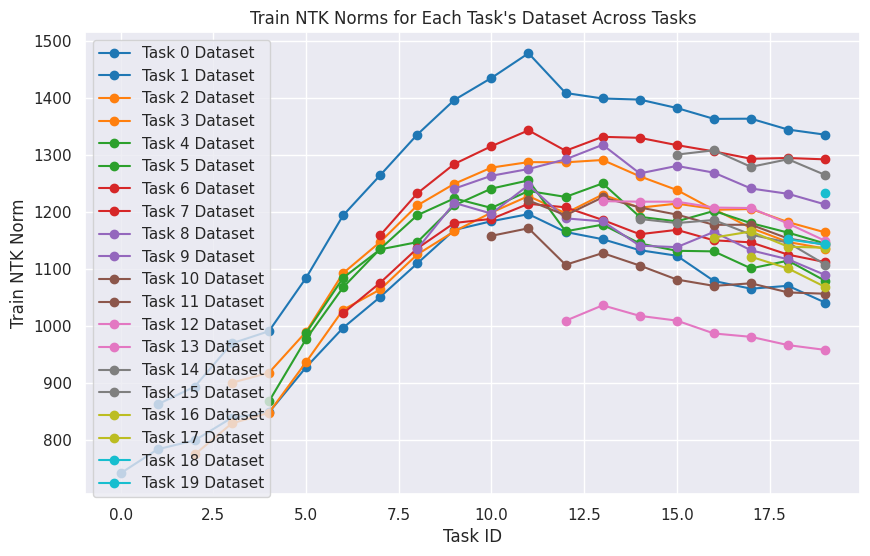

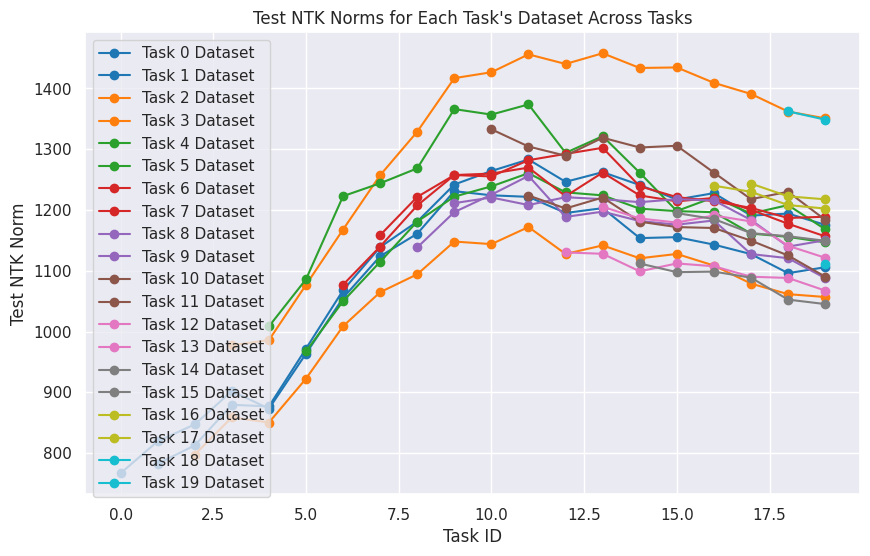

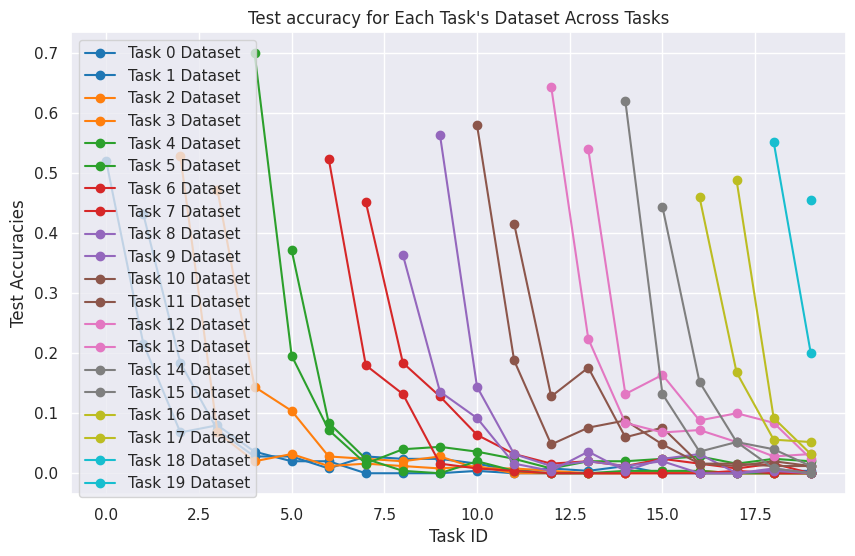

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ntk_norms(ntk_norms, title, ylabel='NTK Norm'):
    """
    Plot NTK norms for each task's dataset across tasks.

    Args:
        ntk_norms (list of lists): NTK norms for each task's dataset.
            ntk_norms[t][i] represents the NTK norm of Task i's dataset after training on Task t.
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(ntk_norms)))  # Assign a color to each task

    for t in range(len(ntk_norms)):
        # Extract NTK norms for Task t's dataset
        ntk_norms_task = [ntk_norms[task_id][t] if task_id >= t else None for task_id in range(len(ntk_norms))]
        
        # Filter out None values (where Task t's dataset is not yet available)
        x_values = [task_id for task_id in range(len(ntk_norms)) if task_id >= t]
        y_values = [ntk_norms_task[task_id] for task_id in x_values]
        
        # Plot the curve for Task t's dataset
        plt.plot(x_values, y_values, marker='o', label=f'Task {t} Dataset', color=colors[t])

    plt.xlabel('Task ID')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_ntk_norms(train_ntk_norms, title='Train NTK Norms for Each Task\'s Dataset Across Tasks', ylabel='Train NTK Norm')

# Plot test NTK norms
plot_ntk_norms(test_ntk_norms, title='Test NTK Norms for Each Task\'s Dataset Across Tasks', ylabel='Test NTK Norm')

plot_ntk_norms(task_accuracies, title='Test accuracy for Each Task\'s Dataset Across Tasks', ylabel='Test Accuracies')


In [ ]:
print(train_ntk_norms)